In [1]:
wd = "/exports/reum/dvanderbijl/"
data_dir = "/exports/reum/nsteinz/data/data_03_12_22/"
results_dir = "/exports/reum/nsteinz/results/"

import os
subproject_name = "trajectories"

wd = "../../../"
project_path = os.path.realpath(wd)
print(project_path)

raw_data_dir = project_path+"/raw_data/"
print(raw_data_dir)


data_dir = project_path+f"/{subproject_name}"+"/data/"
print(data_dir)

results_dir = project_path+f"/{subproject_name}"+"/output"
print(results_dir)



import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.neighbors import NearestNeighbors, KDTree, kneighbors_graph
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PowerTransformer
import sklearn.preprocessing as preprocessing
from sklearn.manifold import TSNE

from sknetwork.clustering import Louvain, get_modularity

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

/exports/reum/nsteinz/Project_trajectories
/exports/reum/nsteinz/Project_trajectories/raw_data/
/exports/reum/nsteinz/Project_trajectories/trajectories/data/
/exports/reum/nsteinz/Project_trajectories/trajectories/output


In [2]:
features = [#'total Pijn',
            'TJC_28',
            #'TJC_44',
            #'total Zwelling',
            'SJC_28',
            #'SJC_44',
            #'Alkalische Fosfatase',
            #'Anti-CCP Kwant.',
            'ESR',
            #'C-Reaktief Proteïne',
            'leukocytes',
            #'Hematocriet',
            #'hemoglobin',
            "hb_corrected",
            #'IgM reumafactor',
                #'Anti-CCP',
            #'MCH',
            #'MCHC',
            'MCV',
            'thrombocytes',
            #'Ferritine',
            #"Sex",
           ]
dmards = ['ABATACEPT',
       'ADALIMUMAB', 'AZATHIOPRINE', 'BARICITINIB', 'CERTOLIZUMAB_PEGOL',
       'CYCLOPHOSPHAMIDE', 'ETANERCEPT', 'GOLIMUMAB', 'HYDROXYCHLOROQUINE',
       'INFLIXIMAB', 'LEFLUNOMIDE', 'METHOTREXATE', 'METHYLPREDNISOLONE',
       'PREDNISOLONE', 'RITUXIMAB', 'SODIUM_AUROTHIOMALATE', 'SULFASALAZINE',
       'TOCILIZUMAB', 'TOFACITINIB']

In [3]:
data_use = pd.read_csv(data_dir+"labeled_data.csv")
#data_use = pd.read_csv(data_dir + "leiden_merged_data.csv")


#X_embedded = TSNE(n_components=2, learning_rate='auto',
#                  init='random', perplexity=100).fit_transform(data_use[list(features)].fillna(0).values)


data_use["das28"] =(0.56*np.sqrt(data_use.TJC_28) + 0.28* np.sqrt( data_use.SJC_28) + 0.70*np.log(data_use.BSE, where= data_use.BSE>0))*1.08 + 0.16

data_cluster = data_use.query("0<=days<=550").reset_index().drop(columns=["level_0","index"])
data_cluster.columns
data_cluster_end = data_cluster.sort_values("DATUM").groupby("PATNR").tail(1)


In [4]:
data_used = data_use[features].fillna(0)
data_used

,TJC_28,SJC_28,ESR,leukocytes,hb_corrected,MCV,thrombocytes
0,0.142857,0.166667,0.323529,0.695614,0.630597,0.903509,0.541231
1,0.071429,0.125000,0.051471,0.403387,0.608209,0.912281,0.307782
2,0.071429,0.083333,0.147059,0.367781,0.708955,1.000000,0.276423
3,0.000000,0.000000,0.125000,0.081633,0.289179,0.789474,0.313589
4,0.000000,0.041667,0.147059,0.231871,0.753731,0.815789,0.298490
...,...,...,...,...,...,...,...
5012,0.000000,0.000000,0.029412,0.231003,0.664179,0.719298,0.311266
5013,0.000000,0.000000,0.000000,0.281372,0.630597,0.701754,0.349593
5014,0.000000,0.000000,0.029412,0.465914,0.697761,0.780702,0.433217
5015,0.000000,0.000000,0.227941,0.470690,0.664179,0.745614,0.462253


scaler =MinMaxScaler( feature_range=(0, 1))
scaler = scaler.fit(data_cluster[features].values)
data_used = scaler.transform(data_cluster[features].fillna(0).values)

In [5]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.mixture import GaussianMixture

def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

def get_score(k, X, y):
    km = get_km(k, X)
    y_pred = km.predict(X)
    bic, aic = get_bic_aic(k, X)
    sil = silhouette_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    hom = homogeneity_score(y, y_pred)
    com = completeness_score(y, y_pred)
    vms = v_measure_score(y, y_pred)
    cal = calinski_harabasz_score(X, y_pred)
    scores = pd.DataFrame([k, bic, aic, sil, db, hom, com, vms, cal], columns=["k", "bic", "aic", "sil", "db", "hom", "com", "vms", "cal"])
    return scores

In [6]:
from phenograph.cluster import cluster as cluster2
import pandas as pd
from scipy import sparse
import numpy as np
import phenograph

from sklearn.metrics import silhouette_score


def cluster_entropy(array:np.ndarray) -> float:
    total = len(array)
    entropy = 0
    for nr in np.unique(array, return_counts=True)[1]:
        entropy +=(nr/total*np.log(nr/total))
    return -entropy/len(set(array))

def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

# Calculating distance
# define a function that will give us the relevant output for the input k
def calc_cluster_characteristics(
        embedding:pd.DataFrame,
        k:int= 10,
        seed:int = 20221003,
        metric="cosine"
    ) -> pd.DataFrame:
    """
    caluculates the clusters and some values to determine the optimal K.
    
    metrics that can be used:
    [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’‘braycurtis’, 
    ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’,
    ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’,
    ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’] 
    """
    print(f"calcualting for k={k}")
    results = pd.Series(dtype = 'float64')
    results['k'] = k 
    
    
    ng = kneighbors_graph(data_used, n_neighbors= k, mode="distance" , include_self=True, metric=metric)
    louv_alg = Louvain(random_state=int(seed)) # metric='minkowski', seed=seed) # random_state=seed,
    lv = louv_alg.fit(ng)
    results['communities'], results['modularity'] = lv.labels_, get_modularity(ng,lv.labels_)
    
    #results['communities'], graph, results['modularity'] = cluster2(embedding, k=k, seed= seed, primary_metric=metric)
    #results['components'] = ng
    results["gini"] = gini_coefficient(results['communities'])
    results["silhouette"] =  silhouette_score(data_used,results['communities'], metric=metric)
    results['entropy'] = cluster_entropy(results['communities'])
    return results






 



In [7]:
ks = np.arange(10, 401, 10) #5 # This is the range of k values we will look at
cluster_chars_list = [calc_cluster_characteristics(k=k,embedding=data_used, metric="cosine") for k in ks]
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()







calcualting for k=10


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=20


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=30


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=40


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=50


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=60


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=70


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=80


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=90


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=100


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=110


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=120


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=130


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=140


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=150


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=160


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=170


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=180


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=190


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=200


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=210


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=220


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=230


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=240


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=250


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=260


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=270


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=280


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=290


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=300


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=310


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=320


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=330


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=340


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=350


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=360


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=370


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=380


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=390


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=400


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [8]:
from sklearn.metrics import adjusted_mutual_info_score
n = len(cluster_characteristics)
ami_indices = pd.DataFrame(np.zeros((n,n)), index = ks, columns = ks)
ami_indices.index.name = 'k1'
ami_indices.columns.name = 'k2'
ami_indices
for i in range(n):
        for j in range(n):
            ami_indices.iloc[i, j] = adjusted_mutual_info_score(
                cluster_characteristics['communities'][i], 
                cluster_characteristics['communities'][j]
            )

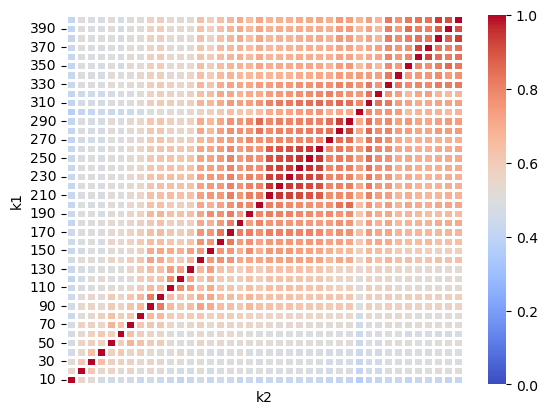

In [9]:
sns.heatmap(ami_indices,
                cmap=('coolwarm'),
                vmin=0,
                vmax=1,
                #cbar_ax=cbar_ax,
                xticklabels=False,
                linewidths=1,
                #ax=axs[1], 
                #title= f"AMI socre"
               ).invert_yaxis()


In [10]:
results_dir+"K-plot_leiden"

'/exports/reum/nsteinz/Project_trajectories/trajectories/outputK-plot_leiden'

## Plot heatmap 

/tmp/ipykernel_903054/104197931.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


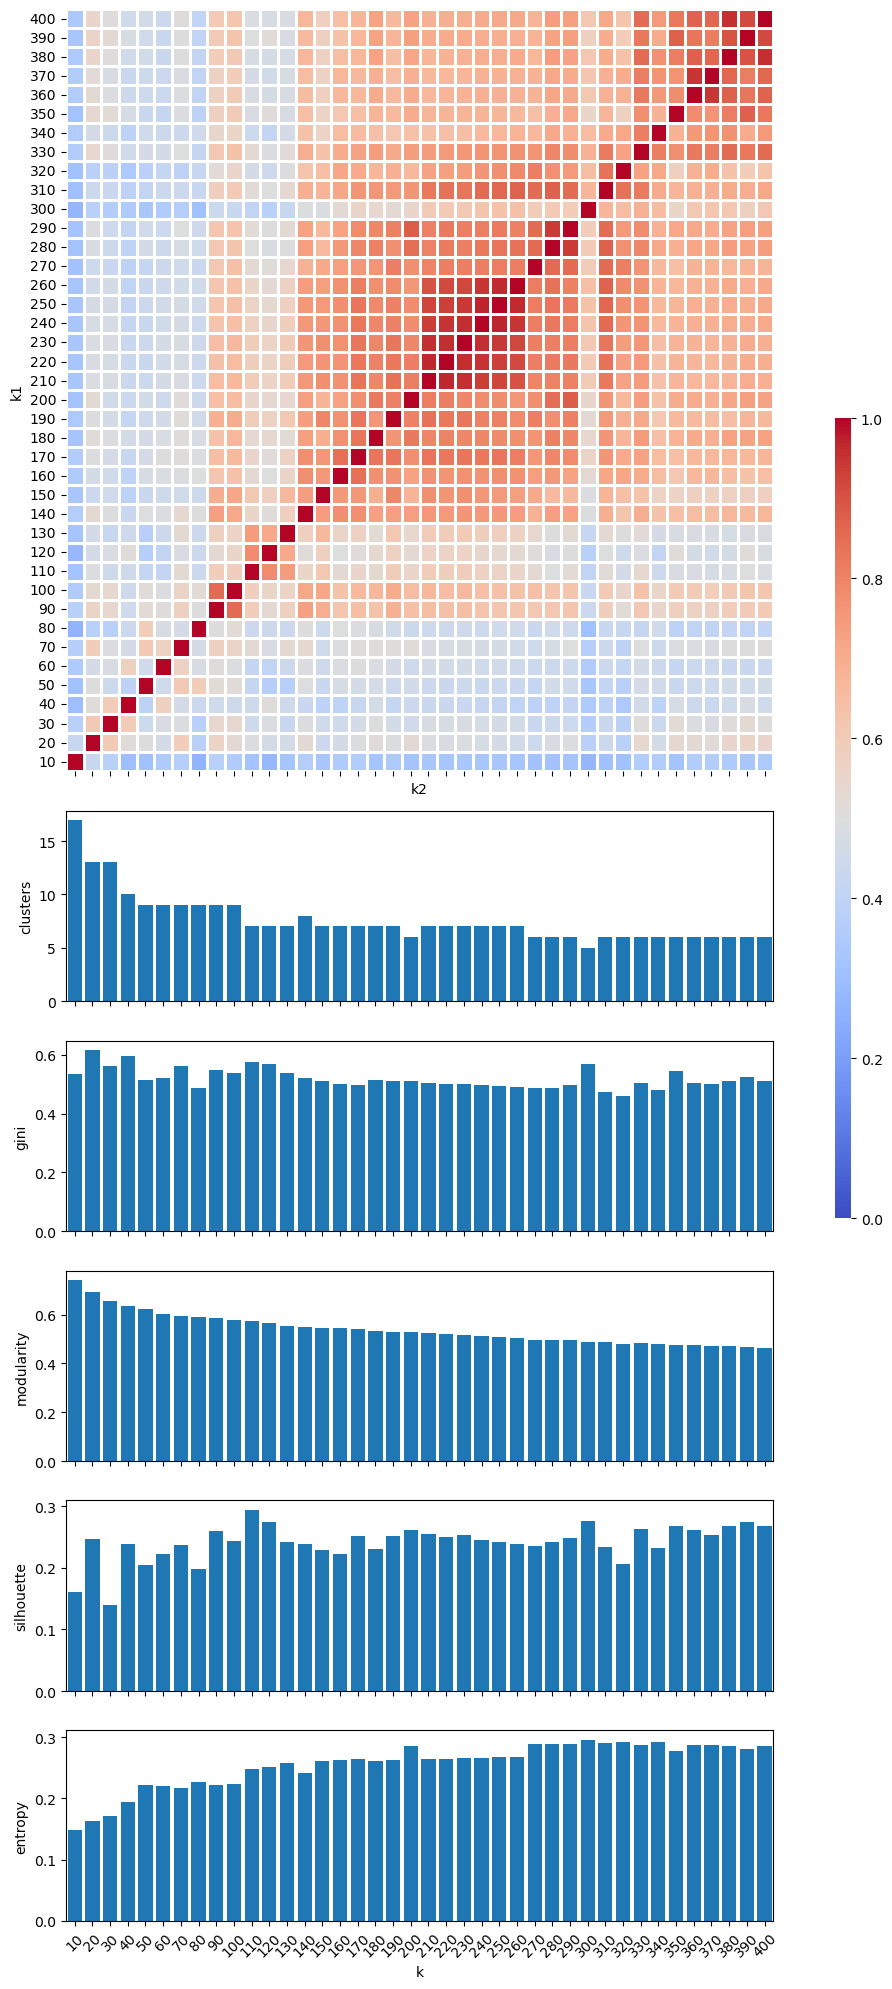

In [11]:
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_mutual_info_score

def plotting(characteristics, title="title"):

    n = len(characteristics)
    Rand_indices = pd.DataFrame(np.zeros((n,n)), index = ks, columns = ks)
    Rand_indices.index.name = 'k1'
    Rand_indices.columns.name = 'k2'
    
    ami_indices = pd.DataFrame(np.zeros((n,n)), index = ks, columns = ks)
    ami_indices.index.name = 'k1'
    ami_indices.columns.name = 'k2'

    for i in range(n):
        for j in range(n):
            Rand_indices.iloc[i, j] = adjusted_rand_score(
                cluster_characteristics['communities'][i], 
                cluster_characteristics['communities'][j]
            )
    cluster_characteristics['clusters'] = cluster_characteristics['communities'].apply(lambda x: len(np.unique(x)))
    
    
    fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(8, 20), sharex='col',
                            gridspec_kw={'height_ratios': [16, 4, 4, 4, 4,4]}
                            )
    cbar_ax = fig.add_axes([1.05, .388, .02, .4]) # square=True, 
    sns.heatmap(Rand_indices,
                cmap=('coolwarm'),
                vmin=0,
                vmax=1,
                cbar_ax=cbar_ax,
                xticklabels=False,
                linewidths=1,
                ax=axs[0], 
                #title= f"rand_index"
               ).invert_yaxis()


    x_ticks = list(Rand_indices.columns)
    x_tick_pos = [i + 0.5 for i in range(len(x_ticks))]

    barplots = ["clusters", "gini", "modularity", "silhouette", "entropy"]
    for ax, name in zip(axs[1:], barplots):
        ax.set_ylabel(name)
        ax.bar(x_tick_pos, characteristics[name], align='center')

    axs[-1].set_xticks(x_tick_pos)
    axs[-1].set_xticklabels(x_ticks, rotation=45)
    axs[-1].set_xlabel('k')
    return fig, axs



plotting(cluster_characteristics)
plt.tight_layout()
plt.savefig(results_dir+"/K-plot_leiden.png", dpi=600, transparent=True, bbox_inches='tight')
plt.show()


In [12]:
list(zip(cluster_characteristics['k'],cluster_characteristics['clusters']))

[(10, 17),
 (20, 13),
 (30, 13),
 (40, 10),
 (50, 9),
 (60, 9),
 (70, 9),
 (80, 9),
 (90, 9),
 (100, 9),
 (110, 7),
 (120, 7),
 (130, 7),
 (140, 8),
 (150, 7),
 (160, 7),
 (170, 7),
 (180, 7),
 (190, 7),
 (200, 6),
 (210, 7),
 (220, 7),
 (230, 7),
 (240, 7),
 (250, 7),
 (260, 7),
 (270, 6),
 (280, 6),
 (290, 6),
 (300, 5),
 (310, 6),
 (320, 6),
 (330, 6),
 (340, 6),
 (350, 6),
 (360, 6),
 (370, 6),
 (380, 6),
 (390, 6),
 (400, 6)]

In [13]:
#ks = np.arange(10, 301, 10) #5 # This is the range of k values we will look at
cluster_chars_list = [calc_cluster_characteristics(k=k,embedding=data_used, metric="minkowski") for k in ks]
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

calcualting for k=10


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=20


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=30


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=40


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=50


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=60


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=70


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=80


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=90


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=100


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=110


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=120


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=130


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=140


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=150


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=160


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=170


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=180


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=190


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=200


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=210


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=220


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=230


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=240


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=250


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=260


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=270


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=280


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=290


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=300


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=310


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=320


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=330


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=340


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=350


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=360


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=370


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=380


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=390


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=400


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


/tmp/ipykernel_903054/2907142933.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


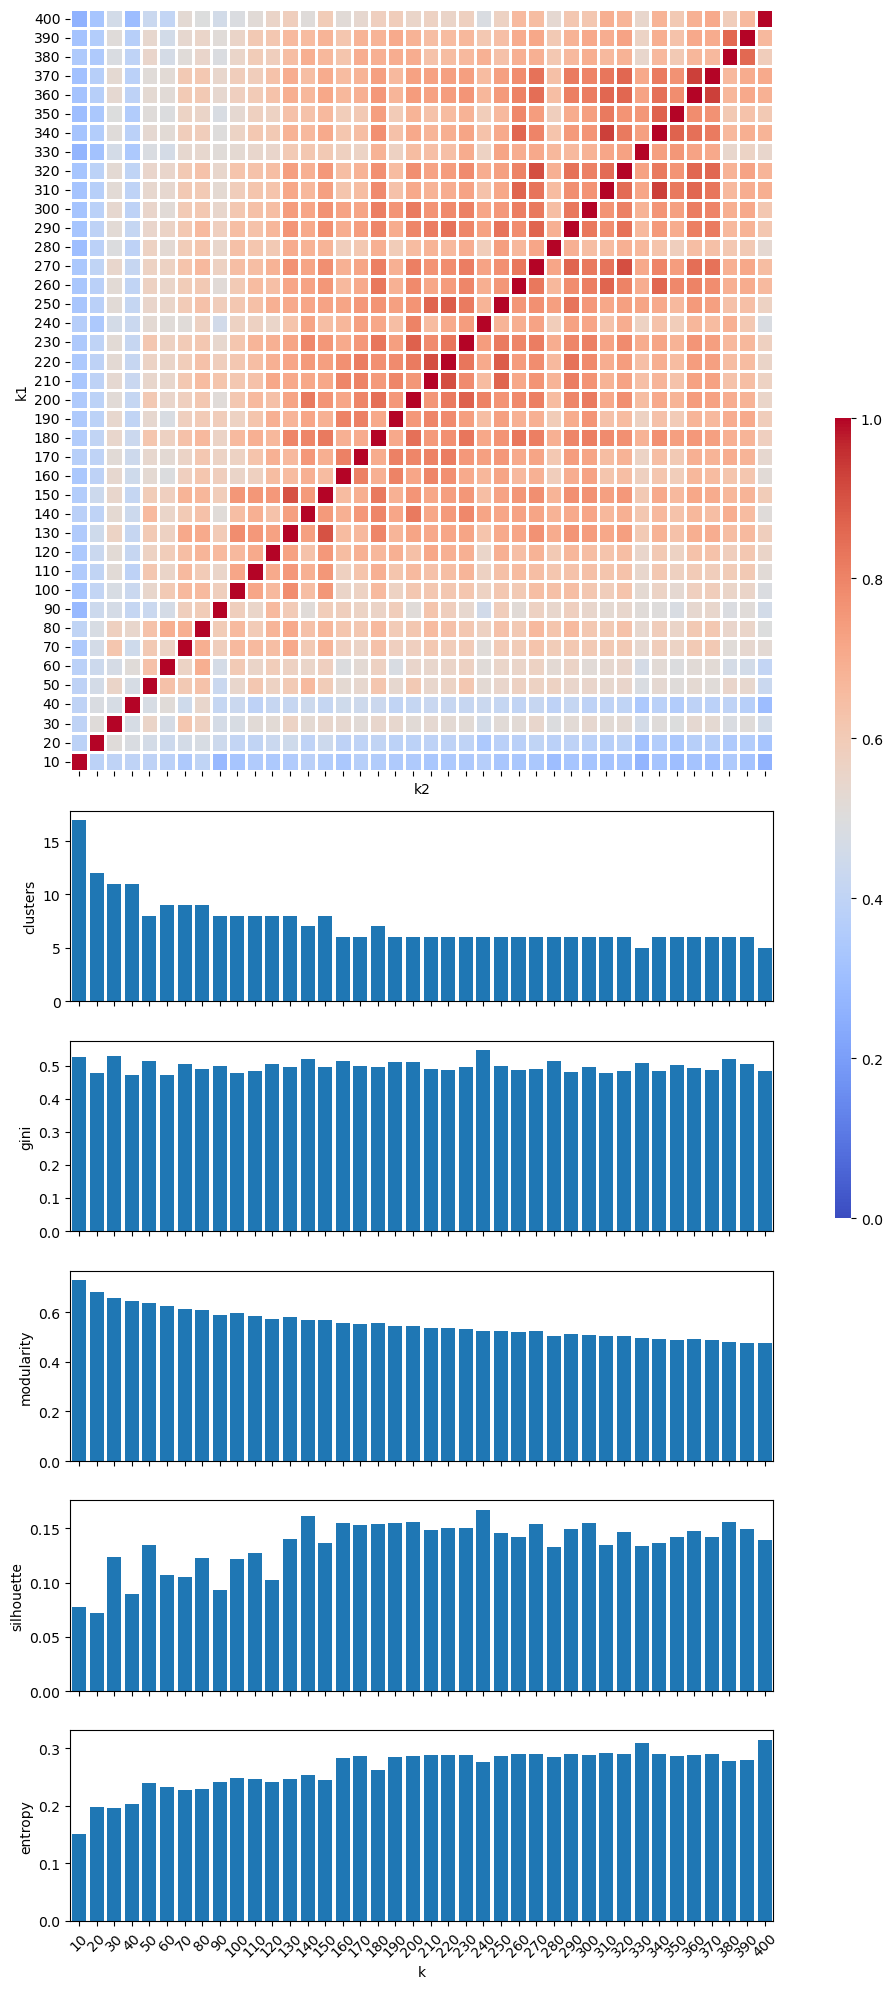

In [14]:
plotting(cluster_characteristics)
plt.tight_layout()
plt.show()

In [15]:
#ks = np.arange(10, 301, 10) #5 # This is the range of k values we will look at
cluster_chars_list = [calc_cluster_characteristics(k=k,embedding=data_used, metric="euclidean") for k in ks]
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

calcualting for k=10


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=20


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=30


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=40


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=50


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=60


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=70


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=80


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=90


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=100


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=110


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=120


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=130


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=140


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=150


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=160


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=170


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=180


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=190


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=200


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=210


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=220


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=230


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=240


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=250


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=260


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=270


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=280


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=290


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=300


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=310


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=320


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=330


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=340


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=350


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=360


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=370


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=380


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=390


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=400


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


/tmp/ipykernel_903054/2907142933.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


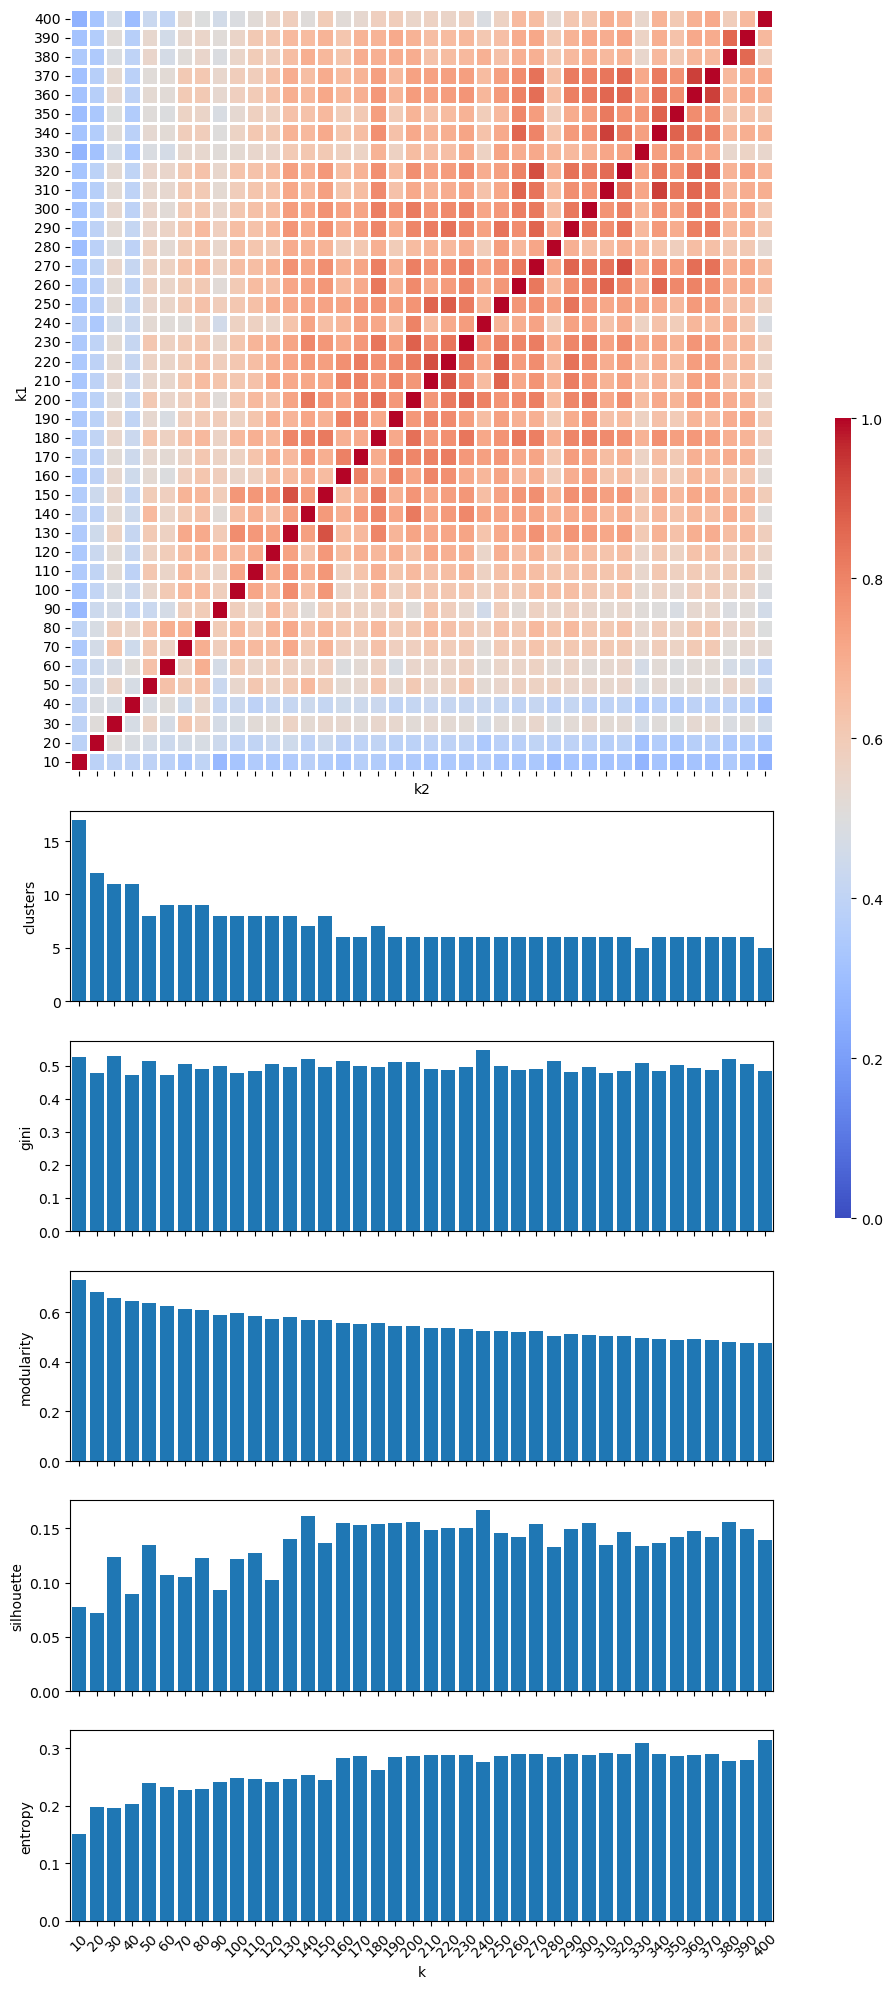

In [16]:
plotting(cluster_characteristics)
plt.tight_layout()
plt.show()

In [17]:
#ks = np.arange(10, 301, 10) #5 # This is the range of k values we will look at
cluster_chars_list = [calc_cluster_characteristics(k=k,embedding=data_used, metric="canberra") for k in ks]
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

calcualting for k=10


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=20


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=30


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=40


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=50


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=60


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=70


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=80


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=90


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=100


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=110


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=120


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=130


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=140


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=150


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=160


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=170


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=180


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=190


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=200


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=210


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=220


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=230


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=240


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=250


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=260


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=270


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=280


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=290


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=300


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=310


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=320


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=330


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=340


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=350


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=360


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=370


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=380


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=390


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


calcualting for k=400


/exports/reum/nsteinz/trajectories/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


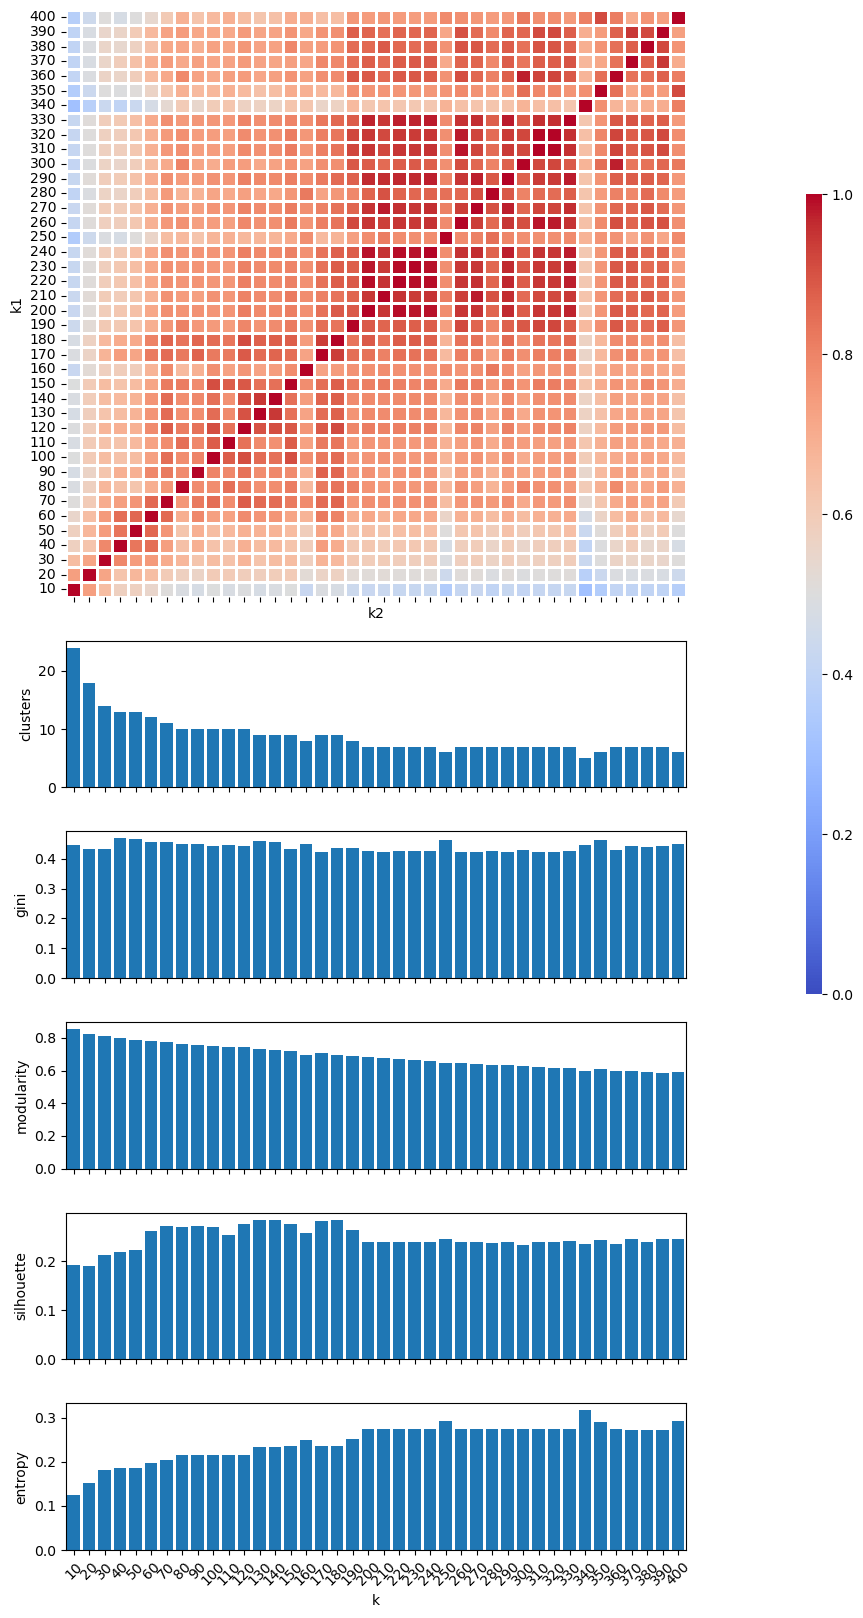

In [18]:
plotting(cluster_characteristics)

plt.show()